In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!pip install -q transformers
!pip install -q sentencepiece
!pip install -q jiwer
!pip install -q datasets
!pip install -q evaluate
!pip install -q -U accelerate


!pip install -q matplotlib
!pip install -q protobuf==3.20.3
!pip install -q tensorboard

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 7.1 MB/s eta 0:00:00


In [3]:
import os
import glob
import tarfile
import torch
import evaluate
import tensorboard
import numpy as np
import pandas as pd
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

from PIL import Image
from tqdm.notebook import tqdm
from dataclasses import dataclass
from torch.utils.data import Dataset, DataLoader
from transformers import (
    VisionEncoderDecoderModel,
    TrOCRProcessor,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    default_data_collator
)

# Inference - TrOCR for text localization-free OCR of IAM handwritten dataset

## 1. Introduction

This notebook contains model inference and evaluations. All models are fine-tuned for 20 epochs.

## 2. Datasets processing

Before begin let's seed everything for reproducibility.

In [4]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### 2.1. Downloading and extracting all IAM full page image dataset into current runtime storage.

In [5]:
def nested_extract_func(dir_path, dest_path):
  print('Extracting the data in {}....'.format(dest_path), end='')
  try:
      with tarfile.open(dir_path, "r:gz") as outer_tgz:
          outer_tgz.extractall(path=dest_path)
      print('Done')
  except Exception as e:
        print('\nInvalid file.', e)

In [6]:
data_path = './gdrive/MyDrive/iam_full_page_dataset/formsA-D.tgz'
target_data_path = './data/full_page_images'

nested_extract_func(dir_path = data_path, dest_path = target_data_path)

Extracting the data in ./data/full_page_images....Done


In [7]:
data_path = './gdrive/MyDrive/iam_full_page_dataset/formsE-H.tgz'
target_data_path = './data/full_page_images'

nested_extract_func(dir_path = data_path, dest_path = target_data_path)

Extracting the data in ./data/full_page_images....Done


In [8]:
data_path = './gdrive/MyDrive/iam_full_page_dataset/formsI-Z.tgz'
target_data_path = './data/full_page_images'

nested_extract_func(dir_path = data_path, dest_path = target_data_path)

Extracting the data in ./data/full_page_images....Done


### 2.2. Loading all test dataframes

#### 2.2.1. Load the DataFrame for 2 consecutive text lines form Google Drive.

In [9]:
dataframe_path = './gdrive/MyDrive/trocr_results/DataFrames/'

In [10]:
lines_x2_test_df = pd.read_csv(dataframe_path+'lines_x2_test_df.csv')

In [11]:
lines_x2_test_df.shape

(350, 8)

In [12]:
lines_x2_test_df.head()

,Unnamed: 0,index,y_start,y_end,x_start,x_end,text,doc_name
0,0,3458,1439,1738,319,2291,"and Red Flag badge, thus presenting a much$bet...",g03-032
1,1,230,1220,1487,338,2260,Presidential election campaign. He claimed$sla...,a01-082u
2,2,3641,1423,1702,386,2196,"fast.... What a gay, lively people, and what a...",g06-011f
3,3,544,718,996,353,2203,"On the other hand, Mr. Pearson excels$in meeti...",a03-050
4,4,3132,1883,2199,408,1954,have joined this train by taking$one from Vict...,f04-096


#### 2.2.2. Load the DataFrame for 4 consecutive text lines form Google Drive.

In [13]:
lines_x4_test_df = pd.read_csv(dataframe_path+'lines_x4_test_df.csv')

In [14]:
lines_x4_test_df.shape

(200, 8)

In [15]:
lines_x4_test_df.head()

,Unnamed: 0,index,y_start,y_end,x_start,x_end,text,doc_name
0,0,3244,1419,2100,343,2340,hesitation in saying that they would have$made...,m03-062
1,1,2321,1578,2260,338,2203,"with a gentle and charming character,$even-tem...",g06-050b
2,2,3619,672,1207,307,2428,Sentence Database P02-109$--------------------...,p02-109
3,3,1187,1607,2290,317,2160,paragraphos markings were omitted. C. H. Rober...,d01-080
4,4,315,1452,2110,342,2240,any increase in budgetary commitments$would al...,a03-066


#### 2.2.3. Load the DataFrame for 8 consecutive text lines form Google Drive.

In [16]:
lines_x8_test_df = pd.read_csv(dataframe_path+'lines_x8_test_df.csv')

In [17]:
lines_x8_test_df.shape

(100, 8)

In [18]:
lines_x8_test_df.head()

,Unnamed: 0,index,y_start,y_end,x_start,x_end,text,doc_name
0,0,1826,703,2095,335,2236,"Gay went out to the waiting$taxi, and then fou...",p02-008
1,1,1736,1225,2657,356,2397,"wherefores of your actions,&quot; he said$stif...",n02-054
2,2,678,736,2065,289,2208,Freedom from want cannot be fulfilled nor$free...,d04-053
3,3,351,717,2145,319,2106,The shock of expulsion from the$Commonwealth n...,b01-132
4,4,1728,730,2130,304,2186,It was all over and done with.$For the time be...,n02-033


#### 2.2.4. Load the DataFrame for 8 to 13 consecutive text lines form Google Drive.

In [19]:
lines_max_test_df = pd.read_csv(dataframe_path+'lines_max_test_df.csv')

In [20]:
lines_max_test_df.shape

(50, 8)

In [21]:
lines_max_test_df.head()

,Unnamed: 0,index,y_start,y_end,x_start,x_end,text,doc_name
0,0,174,916,2238,325,2169,The Notes to the Big Three and a memorandum to...,a06-134
1,1,752,901,2189,367,2260,"For this fairly small group, comparisons betwe...",h04-082
2,2,467,696,2496,345,2269,Drift in another form probably$explains how th...,e06-026
3,3,240,734,2625,297,2190,A policy which breaks with military$alliances ...,b06-042
4,4,667,720,2048,350,2273,In April of that year his first wife's brother...,g06-045a


## 3. Model initialization and data preparation

In [22]:
@dataclass(frozen=True)
class InferenceConfig:
    BATCH_SIZE:    int = 16

@dataclass(frozen=True)
class DatasetConfig:
    DATA_ROOT:     str = './data/'

@dataclass(frozen=True)
class ProcessorlConfig:
    PROCESSOR_NAME: str = 'microsoft/trocr-small-handwritten'

### 3.1. Image augmentations

In [23]:
train_transforms = transforms.Compose([
    transforms.ColorJitter(brightness=0.5, hue=0.3),
    transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 3)),
])

### 3.2. Preparing a custom Dataset class

In [24]:
class IAMCroppedPageDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=128):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # The image file name.
        file_name = self.df['doc_name'][idx]
        # The text (label).
        text = self.df['text'][idx]

        image = Image.open(self.root_dir + file_name + '.png').convert('RGB')
        left = self.df['x_start'][idx]
        top = self.df['y_start'][idx]
        right = self.df['x_end'][idx]
        bottom = self.df['y_end'][idx]
        image = image.crop((left, top, right, bottom))
        image = train_transforms(image)
        pixel_values = self.processor(image, return_tensors='pt').pixel_values
        # Pass the text through the tokenizer and get the labels,
        # i.e. tokenized labels.
        labels = self.processor.tokenizer(
            text,
            padding='max_length',
            max_length=self.max_target_length
        ).input_ids
        # We are using -100 as the padding token.
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]
        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

### 3.3. Preparing the model processor and all test sets for inference

In [25]:
processor = TrOCRProcessor.from_pretrained(ProcessorlConfig.PROCESSOR_NAME)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/276 [00:00<?, ?B/s]

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


tokenizer_config.json:   0%|          | 0.00/327 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/238 [00:00<?, ?B/s]

#### 3.3.1. Test set with 2 consecutive text lines.

In [26]:
lines_x2_test_dataset = IAMCroppedPageDataset(
    root_dir=os.path.join(DatasetConfig.DATA_ROOT, 'full_page_images/'),
    df=lines_x2_test_df,
    processor=processor
)

In [27]:
lines_x2_test_dataloader = DataLoader(lines_x2_test_dataset, InferenceConfig.BATCH_SIZE)

#### 3.3.2. Test set with 4 consecutive text lines.

In [28]:
lines_x4_test_dataset = IAMCroppedPageDataset(
    root_dir=os.path.join(DatasetConfig.DATA_ROOT, 'full_page_images/'),
    df=lines_x4_test_df,
    processor=processor
)

In [29]:
lines_x4_test_dataloader = DataLoader(lines_x4_test_dataset, InferenceConfig.BATCH_SIZE)

#### 3.3.3. Test set with 8 consecutive text lines.

In [30]:
lines_x8_test_dataset = IAMCroppedPageDataset(
    root_dir=os.path.join(DatasetConfig.DATA_ROOT, 'full_page_images/'),
    df=lines_x8_test_df,
    processor=processor
)

In [31]:
lines_x8_test_dataloader = DataLoader(lines_x8_test_dataset, InferenceConfig.BATCH_SIZE)

#### 3.3.4. Test set with 8 to 13 consecutive text lines.

In [32]:
lines_max_test_dataset = IAMCroppedPageDataset(
    root_dir=os.path.join(DatasetConfig.DATA_ROOT, 'full_page_images/'),
    df=lines_max_test_df,
    processor=processor
)

In [33]:
lines_max_test_dataloader = DataLoader(lines_max_test_dataset, InferenceConfig.BATCH_SIZE)

In [34]:
#batch = next(iter(lines_x2_test_dataloader))

In [35]:
#for k,v in batch.items():
#  print(k, v.shape)

### 3.4. Model loading and configurations

#### 3.4.1 Initializing the 2 consecutive line model

In [36]:
@dataclass(frozen=True)
class ModelConfig_x2:
    MODEL_NAME: str = './gdrive/MyDrive/trocr_results/x2_dataset/dollar_sep/checkpoint-5800'

In [37]:
model_x2 = VisionEncoderDecoderModel.from_pretrained(ModelConfig_x2.MODEL_NAME)
model_x2.to(device)
#print(model_x2)
# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model_x2.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model_x2.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

61,596,672 total parameters.
61,596,672 training parameters.


#### 3.4.2 Initializing the 4 consecutive line model

**NOTE:** This model is checkpoint from the 13th epoch. The rest of the model checkpoint were NOT saved due to Google Drive save issues.


In [38]:
@dataclass(frozen=True)
class ModelConfig_x4:
    MODEL_NAME: str = './gdrive/MyDrive/trocr_results/x4_dataset/dollar_sep/checkpoint-2067'

In [39]:
model_x4 = VisionEncoderDecoderModel.from_pretrained(ModelConfig_x4.MODEL_NAME)
model_x4.to(device)
#print(model_x4)
# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model_x4.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model_x4.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

61,596,672 total parameters.
61,596,672 training parameters.


### 3.5. Character Error Rate metric initialization

In [40]:
cer_metric = evaluate.load('cer')

def compute_cer(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer}

In [41]:
#dddd

## 4. Inference

### 4.1. Evaluations on 2 consecutive text lines test set

In [42]:
def evaluation(data, metric, model):
  print("Running evaluation...")

  for batch in tqdm(data):
      # predict using generate
      pixel_values = batch["pixel_values"].to(device)
      outputs = model.generate(pixel_values)

      # decode
      pred_str = processor.batch_decode(outputs, skip_special_tokens=True)
      labels = batch["labels"]
      labels[labels == -100] = processor.tokenizer.pad_token_id
      label_str = processor.batch_decode(labels, skip_special_tokens=True)

      # add batch to metric
      metric.add_batch(predictions=pred_str, references=label_str)

  final_score = metric.compute()
  print("Character error rate on test set:", final_score)

In [44]:
full_page_image_dataset = './data/full_page_images/'

In [45]:
def random_sample_picker(path_dir, samples = 1, recursive = True):
    np.random.seed(42)
    random_samples = []
    for _ in range(samples):
      sample = np.random.choice(glob.glob(path_dir+'/**/*.png', recursive = recursive))
      random_samples.append(sample)
    return random_samples

In [46]:
def sample_visualizer(img_path, model, df = pd.DataFrame(), dim = (2, 5), fsize = (10, 5), title = 'Number', cmap = None):
    rows, columns = dim
    im_index = 0
    fig, axes = plt.subplots(rows, columns, figsize = fsize)
    generated_text_dict = {}

    for row in range(0, rows):
        for col in range(0, columns):
            if df.empty != True:
                random_samples_df = list(df.sample(n = (rows * columns), random_state = 42)['doc_name'])
                sub_image_path = os.path.join(img_path, random_samples_df[im_index]+'.png')
                sub_image = plt.imread(sub_image_path)
                sub_image_name = sub_image_path.split('/')[-1].split('.')[0]
                index = df[df['doc_name'] == sub_image_name].index[0]
 #               word = df['text'].iloc[index]
                y_start = df['y_start'].iloc[index]
                y_end = df['y_end'].iloc[index]
                x_start = df['x_start'].iloc[index]
                x_end = df['x_end'].iloc[index]
                if cmap != 'gray':
                    axes[row, col].imshow(sub_image[y_start:y_end, x_start:x_end])
                else:
                    axes[row, col].imshow(sub_image[y_start:y_end, x_start:x_end], cmap = cmap)
                axes[row, col].set_title('{}: Image idx: {}'.format(title, im_index))

                image = Image.open(sub_image_path).convert("RGB")
                left = x_start
                top = y_start
                right = x_end
                bottom = y_end
                image = image.crop((left, top, right, bottom))
                pixel_values = processor(image, return_tensors="pt").pixel_values.to(device)
                generated_ids = model.generate(pixel_values)
                generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
                generated_text_dict[im_index] = generated_text

                im_index += 1
            else:
                random_samples = random_sample_picker(img_path, samples = (rows * columns))
                sub_image_path = random_samples[im_index]
                sub_image = plt.imread(sub_image_path)
                if cmap != 'gray':
                    axes[row, col].imshow(sub_image)
                else:
                    axes[row, col].imshow(sub_image, cmap = cmap)
                axes[row, col].set_title('{}: Image idx: {}'.format(title, im_index))
                im_index += 1
    return generated_text_dict
    plt.tight_layout()
    plt.show()

In [59]:
def text_visualizer(input_text):
  for idx, txt in input_text.items():
    print('For image: {} Text is: {}'.format(idx, txt))

#### 4.1.1. Evaluations Character error rate on test set

In [43]:
evaluation(data = lines_x2_test_dataloader, metric = cer_metric, model = model_x2)

Running evaluation...


  0%|          | 0/22 [00:00<?, ?it/s]

Character error rate on test set: 0.05804935370152761


#### 4.1.2. Let's take 4 random image samples and generate text for them

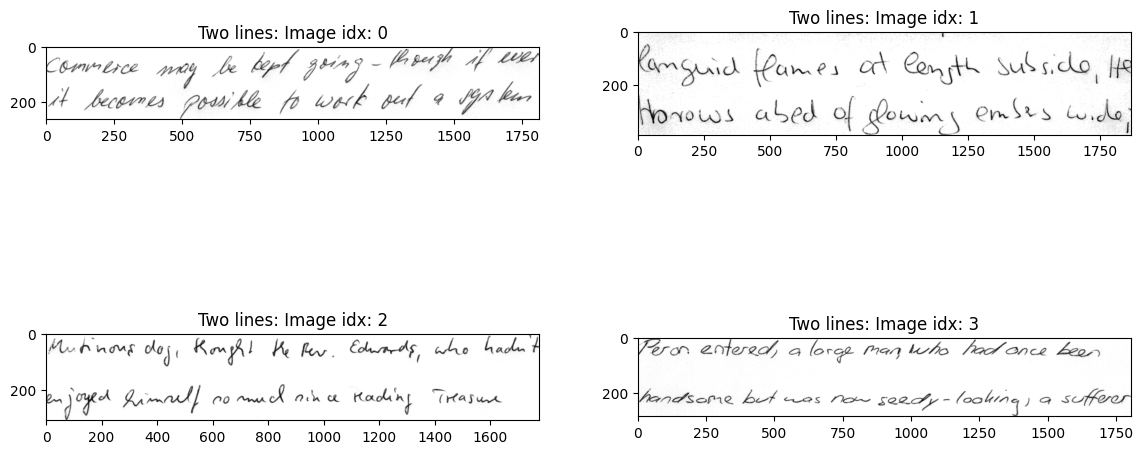

In [47]:
text_x2 = sample_visualizer(full_page_image_dataset, model = model_x2, df = lines_x2_test_df, fsize = (14, 7), dim = (2, 2), title = 'Two lines', cmap = 'gray')

In [60]:
text_visualizer(input_text = text_x2)

For image: 0 Text is: commerce may be best going - though if ever$it becomes possible to work out a system
For image: 1 Text is: languid (Gene at an Alsnicko, He$Horows abed of glowing embers,
For image: 2 Text is: Maritime day, thought the Rev. Edwards, who hadn't$enjoyed himself so much aim a taking treasure
For image: 3 Text is: Peron entered, a large man who had once been$handsome but was now ready-looking, a suffer


### 4.2. Evaluations on 4 consecutive text lines test set

#### 4.2.1. Evaluations Character error rate on test set

In [49]:
evaluation(data = lines_x4_test_dataloader, metric = cer_metric, model = model_x4)

Running evaluation...


  0%|          | 0/13 [00:00<?, ?it/s]

Character error rate on test set: 0.08015626336650603


#### 4.2.2. Let's take 4 random image samples and generate text for them

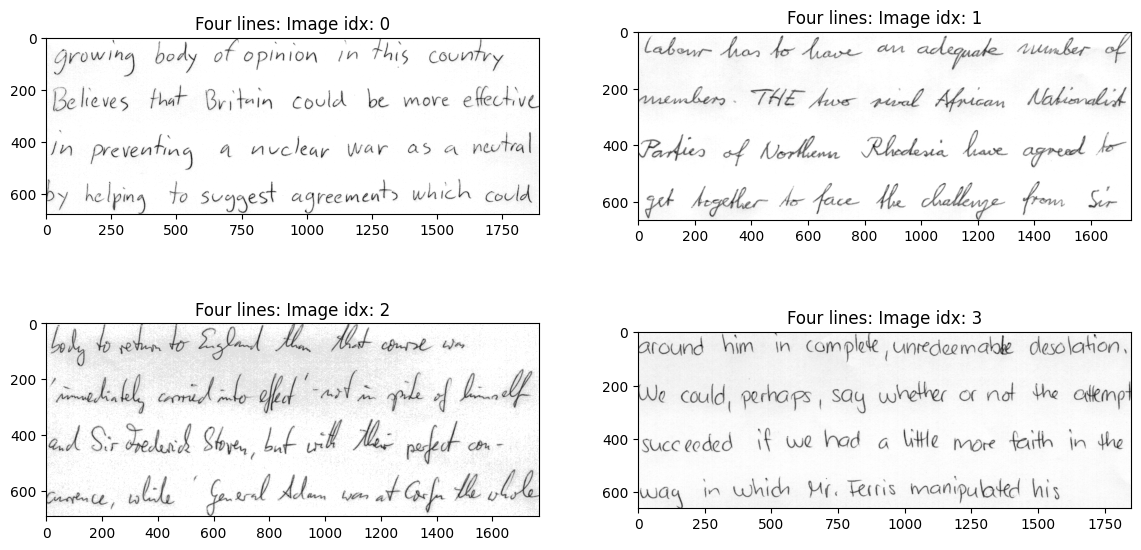

In [50]:
text_x4 = sample_visualizer(full_page_image_dataset, model = model_x4, df = lines_x4_test_df, fsize = (14, 7), dim = (2, 2), title = 'Four lines', cmap = 'gray')

In [61]:
text_visualizer(input_text = text_x4)

For image: 0 Text is: growing body of opinion in this country$believes that Britain could be more effective$in preventing a nuclear war as a neutral$by helping to suggest agreements which could
For image: 1 Text is: Labour has to have an adequate number of$members. THE two rival African Nationalist$Parties of Northern Rhodesia have agreed to$get together to face the challenge from Sir
For image: 2 Text is: body to return to England than that course was$'ninely carried into effect's rest in spite of himself$and Sir Frederick Stoven, but with their perfect con-$carence, while 'General Adam was at Corfu the whole
For image: 3 Text is: around him in complete, unreduous desolation.$We could, perhaps, say whether or not the attempt$succeeded if we had a little more faith in the$way in which Mr. Ferris manipulated his


### 4.3. Evaluations on 4 consecutive text lines dataset

TBD

### 4.4. Evaluations on 8 to 13 consecutive text lines dataset

TBD

### 4.5 Evaluations on 2 consecutive text lines test set with the model trained to generalize 4 text lines

In [52]:
evaluation(data = lines_x2_test_dataloader, metric = cer_metric, model = model_x4)

Running evaluation...


  0%|          | 0/22 [00:00<?, ?it/s]

Character error rate on test set: 0.7709921101225449


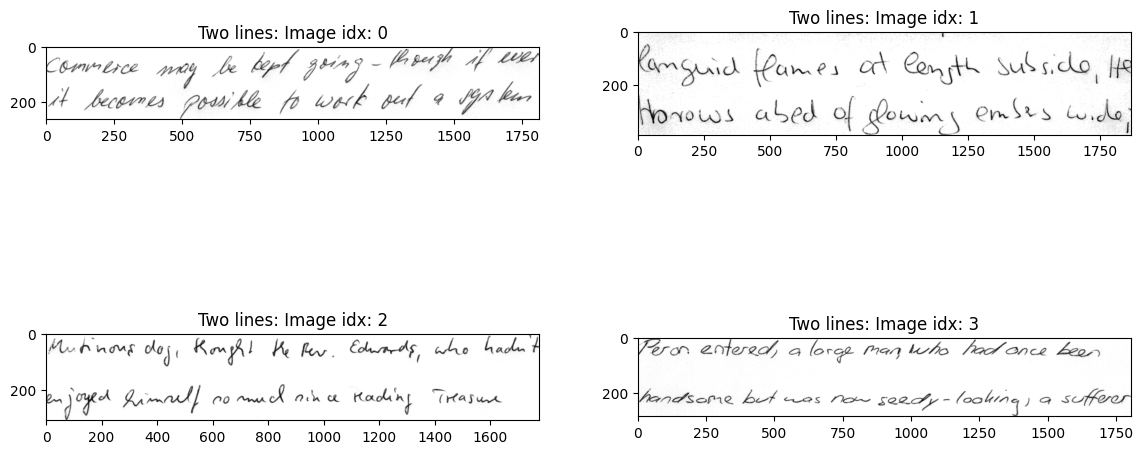

In [53]:
text_x2_model_x4 = sample_visualizer(full_page_image_dataset, model = model_x4, df = lines_x2_test_df, fsize = (14, 7), dim = (2, 2), title = 'Two lines', cmap = 'gray')

In [62]:
text_visualizer(input_text = text_x2_model_x4)

For image: 0 Text is: can be not a bit enough of ever$commence may be very going to$it becomes possible to work out a system$it become possible for work but a system
For image: 1 Text is: PRESIDENTY -$carrying flames at length subside, the$throwes ahead of glowing embers wide;$throws abed of glowing ensues unde,
For image: 2 Text is: Montinous dos, thanks to her Edwards who hadn't$is a good sense.$enjoyed himself to much as taking Treasure$generally so much akin a trading treasure
For image: 3 Text is: Propr entered, along man who had once been$been$handsome but was now looking a sufferer$handsame but was new steady-looking, a suffer or$hand was now steady-robing, a stiffer


The model which is trained for long sequences is trying to generate more text than the image contains. Probably the generation methods and their setting should be tuned too.

### 4.6 Evaluations on 4 consecutive text lines test set with the model trained to generalize 2 text lines

In [55]:
evaluation(data = lines_x4_test_dataloader, metric = cer_metric, model = model_x2)

Running evaluation...


  0%|          | 0/13 [00:00<?, ?it/s]

Character error rate on test set: 0.6159571131198495


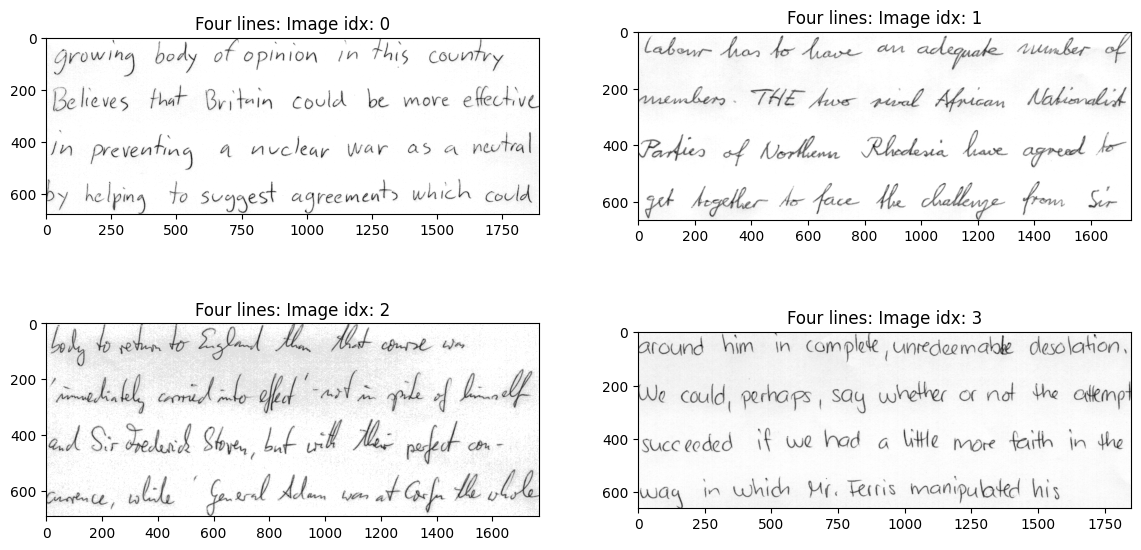

In [56]:
text_x4_model_x2 = sample_visualizer(full_page_image_dataset, model = model_x2, df = lines_x4_test_df, fsize = (14, 7), dim = (2, 2), title = 'Four lines', cmap = 'gray')

In [63]:
text_visualizer(input_text = text_x4_model_x2)

For image: 0 Text is: growing body of opinion in this connection$in preventing a nuclear war as a neutral
For image: 1 Text is: Labour has to have an adequate subject of$Posties of Northern Rhodesia have opened to
For image: 2 Text is: Lady to return to England, along that course in himself, and Sir Frederick Stoven, but will then rocket you can be
For image: 3 Text is: spread, high in complete, unproved the development succeeded if we had a little more faith in the


A very interesting observation here is that the model 'reads' the lines through one.

## 5. Discussion

In literature OCR models with CER < 10% are considered as 'acceptable', but OCR models with CER < 5% are considered as good. $TrOCR_{small}$ shows CER performance below 10% which is very good considering the short training cycle of 20 epoch. Bigger TrOCR models should perform better on this generalization task.

Additionally, all trained models can be evaluated on a IAM single text line dataset. Depending on the performance, information can be obtained as to whether the model degrades while learning longer sequences.

As a continuation of the study, the remaining 2 models can be trained until the IAM full page dataset is fully generalized. This can give a more comprehensive assessment of the generalizability of the model. The other 2 larger models can also be trained.

According of the results from the 'mixed' test - obviously the models expect images with the exact number of text lines as these in their training sets. This is expected. To fine-tune the model which can recognize a full page of text and the same page with only one text line on it, maybe the last model should be randomly trained with data with different sequence.

Or maybe the other approach is to create a large set of mixed data of varying length and continuously train on it. All of these hypothesis can be tested.


